In [1]:
import torch
import torchvision.ops
from torchvision import transforms
from tqdm import trange
from src.dataloader import FasterRCNNData
from src.model import faster_rcnn 
import src.transforms as t
import src.utils
import skimage.io as io

from tqdm.notebook import tqdm
from itertools import product
from importlib import reload
from typing import Dict, List, Union

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
norm = t.normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
model = faster_rcnn
model.load_state_dict(torch.load('modelfiles/yeet.mdl'))
model.eval().to(device)
print(' ')


Load Image and preprocess

In [6]:
image = io.imread('data/4m NS 211 NS G-Iba1 small.tif')
image.shape

(3785, 3600)

  0%|          | 0/342 [00:00<?, ?it/s]

tensor(0.0653)
tensor(0.1119)
tensor(0.4208)
tensor(0.1214)
tensor(0.1370)
tensor(0.3255)
tensor(0.4988)
tensor(0.1498)
tensor(0.0968)
tensor(0.0870)
tensor(0.0768)
tensor(0.0627)
tensor(0.0895)
tensor(0.0979)
tensor(0.1314)
tensor(0.1665)
tensor(0.1345)
tensor(0.0694)
tensor(0.1348)
tensor(0.2713)
tensor(0.1486)
tensor(0.0542)
tensor(0.0831)
tensor(0.0937)
tensor(0.0708)
tensor(0.1012)
tensor(0.1648)
tensor(0.6901)
tensor(0.0934)
tensor(0.1057)
tensor(0.1594)
tensor(0.6266)
tensor(0.6629)
tensor(0.1106)
tensor(0.1661)
tensor(0.2164)
tensor(0.4512)
tensor(0.4800)
tensor(0.2064)
tensor(0.1152)
tensor(0.1878)
tensor(0.1651)
tensor(0.1513)
tensor(0.1634)
tensor(0.1157)
tensor(0.1140)
tensor(0.0765)
tensor(0.1241)
tensor(0.0547)
tensor(0.1202)
tensor(0.2407)
tensor(0.0817)
tensor(0.2164)
tensor(0.3423)
tensor(0.3423)
tensor(0.3423)
tensor(0.0770)
tensor(0.1107)
tensor(0.3423)
tensor(0.0742)
tensor(0.3423)
tensor(0.9967)
tensor(0.0571)
tensor(0.0947)
tensor(0.1074)
tensor(0.0983)
tensor(0.3

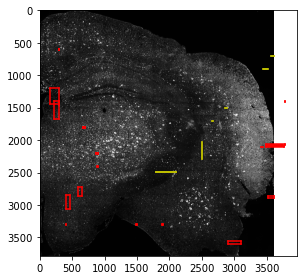

In [14]:
pad = 50
im_size = 200
eval_im_size = pad *2 + im_size

x_ind = src.utils.calculate_indexes(pad, im_size, image.shape[0], image.shape[0])
y_ind = src.utils.calculate_indexes(pad, im_size, image.shape[1], image.shape[1])

indexes = product(x_ind, y_ind)
results = {'out_dict':[], 'x':[], 'y': []}

with torch.no_grad():
    for ([x0, x1], [y0,y1]) in tqdm(indexes, total=len(x_ind) * len(y_ind)):
        c = torch.zeros((1, eval_im_size-1, eval_im_size-1), device=device)
        im = torch.cat((c, 
                           torch.from_numpy(image[x0:x1, y0:y1]).to(device).unsqueeze(0), 
                           c), dim=0)

        im= norm({'image': im})['image']
        out = {}
        for k,v in model([im])[0].items(): # funky but this evaulates model
            out[k] = v.cpu()
            
        try:
            print(out['scores'].max())
        except RuntimeError:
            pass
        
        results['out_dict'].append(out)
        results['x'].append([x0, x1])
        results['y'].append([y0, y1])


    results = src.utils.merge_results_dict(results)
    ind = torchvision.ops.nms(results['boxes'], results['scores'], 0.5)
    
    for k in results:
        results[k] = results[k][ind,...]

src.utils.render_boxes(torch.from_numpy(image), results, 0.2)